In [36]:
import sys
import os

import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer
from transformer_lens import HookedTransformer

sys.path.append(f'{os.getcwd()}/../')

from lm_polygraph.stat_calculators import EntropyCalculator
from prompts import w_context_user_prompt, w_context_system_prompt, wo_context_system_prompt

In [11]:
def store_activations(activation_dict):
    def hook_fn(activation, hook):
        activation_dict[hook.name] = activation.detach()
    return hook_fn

def layer_wise_entropy(activation_dict, model) -> torch.tensor:
    """
    Given stored activations from each layer (residual stream),
    apply ln_final and unembed to get entropy per layer for 1 token.
    """
    logit_lens = []
    estimator = EntropyCalculator()
    
    for state in range(model.cfg.n_layers):
        resid = activation_dict[f"blocks.{state}.hook_resid_post"] # shape: [batch, seq_len, d_model]
        logits = model.ln_final(resid) # shape: [batch, seq_len, d_model]
        logits = model.unembed(logits) # shape: [batch, seq_len, vocab_size]
        last_token_resid = logits[:, -1, :] # shape: [batch, vocab_size]
        log_probs = F.log_softmax(last_token_resid, dim=-1).detach().cpu().unsqueeze(dim=0) # shape: [1, batch, vocab_size]
        uncertainty = estimator({"greedy_log_probs": np.array(log_probs)})['entropy'][0][0] # shape: n
        logit_lens.append(uncertainty)
        
    return torch.tensor(logit_lens) # shape: [n_layers]
    
def layer_token_wise_entropy(tokens, model, max_new_tokens):
    """
    
    """
    entropies = []
    for step in range(max_new_tokens):
        activation_store = {}
        
        with torch.no_grad():
            # Run model with hooks to capture residual activations
            logits = model.run_with_hooks(
                tokens,
                return_type="logits",
                fwd_hooks=[(f"blocks.{i}.hook_resid_post", store_activations(activation_store)) 
                           for i in range(model.cfg.n_layers)],
            )
        
        logits = logits.detach().cpu()
    
        # Get the final next-token prediction from the model
        final_logits = logits[:, -1, :]
        next_token_id = torch.argmax(final_logits, dim=-1, keepdim=True)
        
        # Store the entropies for this step
        entropies.append(layer_wise_entropy(activation_store, model))
        
        # Append the predicted token to the input for the next iteration
        tokens = torch.cat([tokens, next_token_id.to(device)], dim=-1)
        
        if model.to_str_tokens(next_token_id)[0] ==  "<|eot_id|>":
            break
            
    return torch.stack(entropies, dim=0) # shape: [num_new_tokens, n_layers]

In [21]:
def calculate_entropies_in_dataset(dataset, context_mode, model, tokenizer, max_new_tokens):
    all_entropies = []
    all_eos = []
    
    assert (context_mode in ('original', 'small', 'no_context'))
    
    for _, row in tqdm(dataset.iterrows(), total=len(dataset)):
        if context_mode == 'original':
            text = tokenizer.apply_chat_template([
                {"role": "user", "content": w_context_user_prompt(row['question'], row['context'])}, 
                {"role": "system", "content": w_context_system_prompt()}
            ], tokenize=False, add_generation_prompt=True)
            
        elif context_mode == 'small':
            text = tokenizer.apply_chat_template([
                {"role": "user", "content": w_context_user_prompt(row['question'], row['small_context'])}, 
                {"role": "system", "content": w_context_system_prompt()}
            ], tokenize=False, add_generation_prompt=True)
            
        else: # 'no_context'
            text = tokenizer.apply_chat_template([
                {"role": "user", "content": row['question']}, 
                {"role": "system", "content": wo_context_system_prompt()}
            ], tokenize=False, add_generation_prompt=True)
            
        tokens = model.to_tokens(text, prepend_bos=False).to(device)
        entropy = layer_token_wise_entropy(tokens, model, max_new_tokens)
        eos_entropy = entropy[-1]  # shape: [n_layers]
        entropy = entropy[:-1] # shape: [num_new_tokens, n_layers]
        
        all_entropies.append(entropy)
        all_eos.append(eos_entropy)
        
    return all_entropies, all_eos

In [13]:
nq_dataset = pd.read_csv('data/nq_1sentence_context.csv')

cfg = OmegaConf.load("config.yaml")
device = "cuda:0" if torch.cuda.is_available() else "cpu"

tokenizer = AutoTokenizer.from_pretrained(cfg.model_id)
model = HookedTransformer.from_pretrained(
    cfg.model_id,
    device=device,
    tokenizer=tokenizer,
)
model.set_use_attn_result(True)
model.eval()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pretrained model meta-llama/Llama-3.2-3B-Instruct into HookedTransformer


HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (blocks): ModuleList(
    (0-27): 28 x TransformerBlock(
      (ln1): RMSNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): RMSNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): GroupedQueryAttention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
        (hook_rot_k): HookPoint()
        (hook_rot_q): HookPoint()
      )
      (mlp): GatedMLP(
        (hook_pre): HookPoint()
        (hook_pre_linear): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_att

In [40]:
max_new_tokens = int(nq_dataset['reference'].apply(len).mean())

small_context_entropies, small_context_entropies_eos = calculate_entropies_in_dataset(nq_dataset, 'small', model, tokenizer, max_new_tokens)
original_context_entropies, original_context_entropies_eos = calculate_entropies_in_dataset(nq_dataset, 'original', model, tokenizer, max_new_tokens)
no_context_entropies, no_context_entropies_eos = calculate_entropies_in_dataset(nq_dataset, 'no_context', model, tokenizer, max_new_tokens)

100%|██████████| 69/69 [03:21<00:00,  2.93s/it]


In [41]:
small_context_entropies = [entropy[0][2].item() for entropy in small_context_entropies]
original_context_entropies = [entropy[0][2].item() for entropy in original_context_entropies]
no_context_entropies = [entropy[0][2].item() for entropy in no_context_entropies]

small_context_entropies_eos = [entropy[-1].item() for entropy in small_context_entropies_eos]
original_context_entropies_eos = [entropy[-1].item() for entropy in original_context_entropies_eos]
no_context_entropies_eos = [entropy[-1].item() for entropy in no_context_entropies_eos]

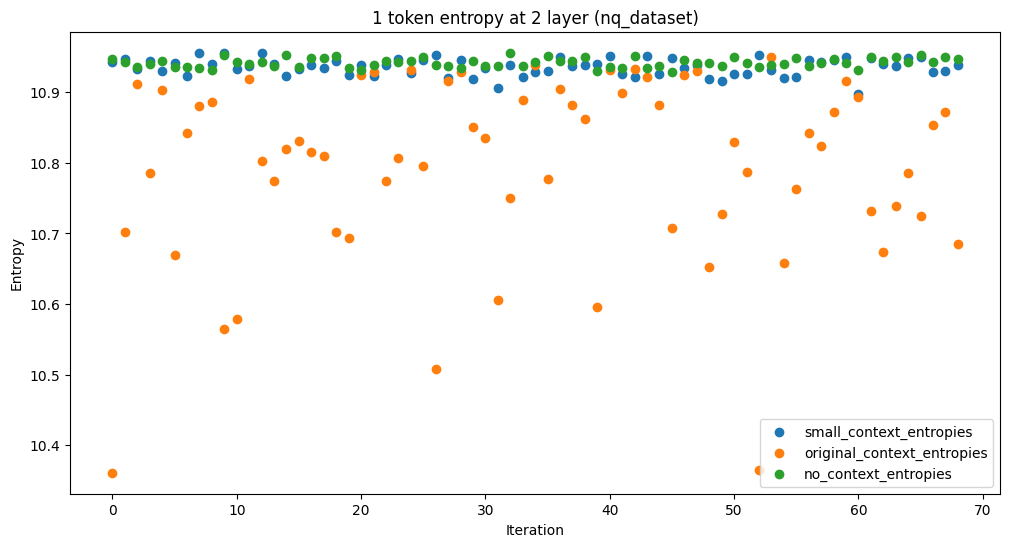

In [42]:
token_1 = {
    'small_context_entropies': small_context_entropies, 
    'original_context_entropies': original_context_entropies, 
    'no_context_entropies': no_context_entropies
}

plt.figure(figsize=(12, 6))
for key, values in token_1.items():
    plt.scatter(range(len(values)), values, label=key)

plt.xlabel('Iteration')
plt.ylabel('Entropy')
plt.title('1 token entropy at 2 layer (nq_dataset)')
plt.legend()
plt.show()

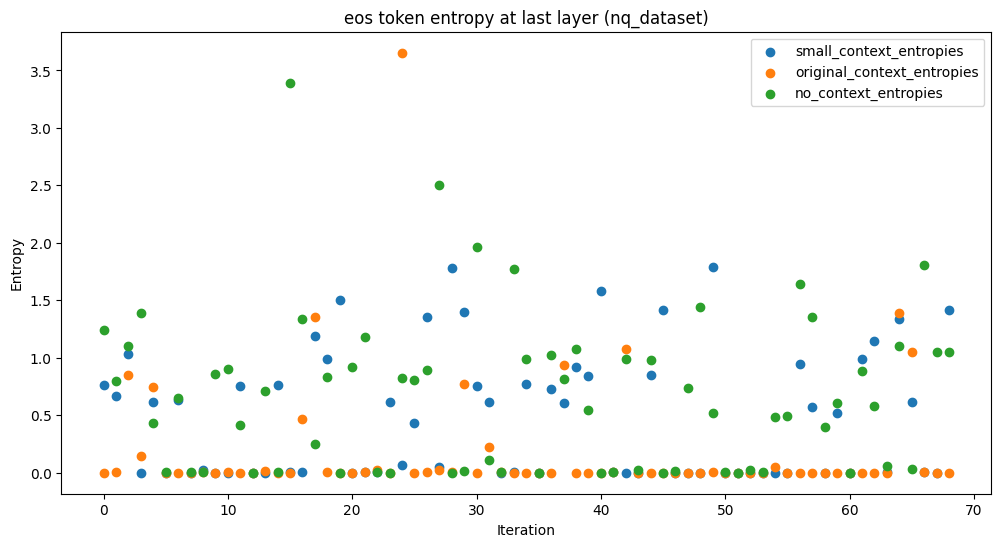

In [45]:
token_eos = {
    'small_context_entropies': small_context_entropies_eos, 
    'original_context_entropies': original_context_entropies_eos, 
    'no_context_entropies': no_context_entropies_eos
}

plt.figure(figsize=(12, 6))
for key, values in token_eos.items():
    plt.scatter(range(len(values)), values, label=key)

plt.xlabel('Iteration')
plt.ylabel('Entropy')
plt.title('eos token entropy at last layer (nq_dataset)')
plt.legend()
plt.show()